In [144]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [145]:
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import random
import re
import sys
from astropy.io import fits
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchmetrics import Dice
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import segmentation_models_pytorch as smp

In [146]:
hiperparametros = {'nombre_notebook': 'Training_VIS_1000imgs_v2.ipynb',
                    'nombre_experimento' : 'Training_VIS_1000imgs_v2',
                    'nombre_mejor_modelo_a_guardar' : 'VIS_1000imgs_v2',
                    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                    'ruta_galaxias' : 'galaxies_train_VIS/galaxy_and_stream_convolved*',
                    'ruta_mascaras' : '../masks_VIS/mask_',
                    'ruta_galaxias_test' : 'galaxies_test_VIS/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras_test' : '../masks_VIS/mask_',
                    'ancho_imagen_original' : 600,
                    'alto_imagen_original' : 600,
                    'ancho_imagen_deseado' : 608,
                    'alto_imagen_deseado' : 608,
                    'epocas' : 500,
                    'lr' : 1e-3,
                    'regularizacion_ridge' : 1e-5,
                    'torch seed model weights' : 10,
                    'batch_size' : 4,
                    'loss' : torch.nn.CrossEntropyLoss()}

In [147]:
device = hiperparametros['device']

In [148]:
def get_galaxy_number(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[4]

def get_galaxy_magnitude(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[5]

def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def imagen_logaritmica(img: np.ndarray)->np.ndarray:
    """
    Escalamos de forma logarítmica la imagen para aumentar el contraste
    """
    img_log = np.log(img, where=(img!=0))
    valor_minimo = np.min(img_log)
    np.putmask(img_log, img!=0, img_log+abs(valor_minimo))
    return img_log


In [149]:
class MyDataset(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)
    
class MyDatasetTest(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras_test']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        #x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)

In [150]:
augmentation = A.Compose([
    A.Flip(p=0.8),
    #A.Rotate(limit=(-180, 180), border_mode='random', p=0.99), 
    A.ShiftScaleRotate(shift_limit=0.4, rotate_limit=180, p=0.8),
    A.GaussNoise(var_limit=(0.001), mean=(0.04), p=0.99),
    ToTensorV2(),
])

In [151]:
imagenes_train = glob.glob(hiperparametros['ruta_galaxias'])
imagenes_valid = glob.glob(hiperparametros['ruta_galaxias_test'])
print("Number of train images: " + str(len(imagenes_train)))
print("Number of valid images: " + str(len(imagenes_valid)))
dataset_augmentations = MyDataset(imagenes_train, augmentation)
train_dataset= ConcatDataset([dataset_augmentations])
valid_dataset= MyDatasetTest(imagenes_valid)
train_dataloader = DataLoader(train_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)

Number of train images: 6963
Number of valid images: 1746


## Creación del modelo

In [152]:
unet = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [153]:
torch.manual_seed(hiperparametros['torch seed model weights'])
unet.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [154]:
#Imprimimos la arquitectura de la red
summary(unet, (1, 608, 608))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 304, 304]           3,136
       BatchNorm2d-2         [-1, 64, 304, 304]             128
              ReLU-3         [-1, 64, 304, 304]               0
         MaxPool2d-4         [-1, 64, 152, 152]               0
            Conv2d-5         [-1, 64, 152, 152]          36,864
       BatchNorm2d-6         [-1, 64, 152, 152]             128
              ReLU-7         [-1, 64, 152, 152]               0
            Conv2d-8         [-1, 64, 152, 152]          36,864
       BatchNorm2d-9         [-1, 64, 152, 152]             128
             ReLU-10         [-1, 64, 152, 152]               0
       BasicBlock-11         [-1, 64, 152, 152]               0
           Conv2d-12         [-1, 64, 152, 152]          36,864
      BatchNorm2d-13         [-1, 64, 152, 152]             128
             ReLU-14         [-1, 64, 1

In [155]:
#Comprobamos que hemos construido la arquitectura de la red correctamente cargando una imagen del dataset
input_item, label_item = train_dataset.__getitem__(22)
# Guardar input_item
plt.imshow(input_item.squeeze(), interpolation='none', origin='lower')
plt.axis('off')  # Desactivar los ejes
plt.savefig('images_paper/input_item.png', bbox_inches='tight', pad_inches=0)
plt.close()  # Cerrar la figura actual para evitar superposición

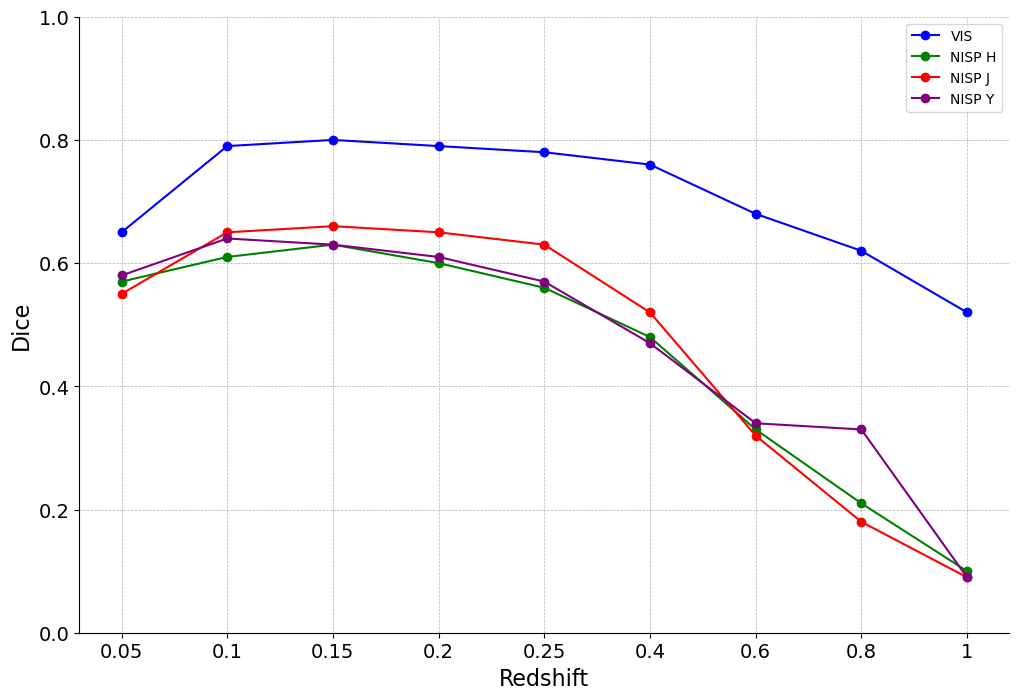

In [1]:
resultados = {
    '0.05':[],
    '0.1':[],
    '0.15':[],
    '0.2':[],
    '0.25':[],
    '0.4':[],
    '0.6':[],
    '0.8':[],
    '1':[],
}

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ejemplo de datos (puedes reemplazar con tus datos reales)
redshifts = list(resultados.keys())
medias1 = [0.65, 0.79, 0.80, 0.79, 0.78, 0.76, 0.68, 0.62, 0.52]
medias2 = [0.57, 0.61, 0.63, 0.60, 0.56, 0.48, 0.33, 0.21, 0.10]
medias3 = [0.55, 0.65, 0.66, 0.65, 0.63, 0.52, 0.32, 0.18, 0.09]
medias4 = [0.58, 0.64, 0.63, 0.61, 0.57, 0.47, 0.34, 0.33, 0.09]

# Crear una paleta de colores en función de los valores alcanzados, normalizada entre 0 y 1
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el gráfico de líneas
line_colors = [sm.to_rgba(valor) for valor in medias1]
ax = plt.gca()

# Añadir cada serie de datos al gráfico
ax.plot(redshifts, medias1, label='VIS', color='blue', marker='o')
ax.plot(redshifts, medias2, label='NISP H', color='green', marker='o')
ax.plot(redshifts, medias3, label='NISP J', color='red', marker='o')
ax.plot(redshifts, medias4, label='NISP Y', color='purple', marker='o')

# Ajustar los límites del eje y entre 0 y 1
ax.set_ylim(0, 1)
"""
# Añadir etiquetas con los valores sobre las líneas
for i, valor in enumerate(medias1):
    ax.text(redshifts[i], valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
for i, valor in enumerate(medias2):
    ax.text(redshifts[i], valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
for i, valor in enumerate(medias3):
    ax.text(redshifts[i], valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
for i, valor in enumerate(medias4):
    ax.text(redshifts[i], valor + 0.01, f'{valor:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
"""
# Añadir un título y ajustar etiquetas
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Dice', fontsize=16)

# Ajustar el tamaño de las etiquetas de los ejes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Añadir líneas de cuadrícula
ax.grid(True, linestyle='--', linewidth=0.5)

# Mejorar el diseño general
sns.despine()
plt.legend()
plt.savefig('images_paper/comparison_filters.png', dpi=300, bbox_inches='tight')
# Mostrar el gráfico
plt.show()